# Tarea 2
## Francisco Javier Peralta Ramírez

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp

import warnings
sp.init_printing()
warnings.filterwarnings('ignore')

In [2]:
def adagrad(f, gradf, x0, nIter, alpha):
    pass

def nag(f, gradf, x0, nIter, alpha):
    pass

def adam(f, gradf, x0, nIter, alpha):
    pass

Codificamos la función rosembrock como un simple **for**

In [34]:
def rosenbrock(x):
    fx = 0
    for i in range(len(x) - 1):
        fx += 100 * (x[i+1] - x[i]**2)**2 + (1 - x[i]**2)
    return fx

Como la función *rosenbrock* admite cualquier tipo (i.e. no se hace chequeo de tipos) podemos pasar simbolos de *sympy*

In [9]:
x = sp.symbols('x1:3')
rosembrock(x)

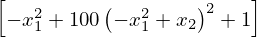

In [10]:
ros = sp.Matrix([rosembrock(x)])
ros

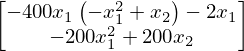

In [65]:
jacRos = ros.jacobian(x).T
jacRos

Podemos evaluar el resultado del gradiente usando la función **subs** la cual substituye las variables por valores, esta requiere un parámetro de la forma ***[ (old, new), ... ]*** donde *old* es la variable a remplazar y *new* el valor.

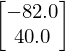

In [36]:
x0 = [1, 1.2]
evalJ = jacRos.subs([(x[i], x0[i]) for i in range(len(x0))])
evalJ

Podemos juntar todo esto para crear una función que regresa el gradiente

In [68]:
def sym_grad(f, x):
    x_s = sp.symbols('x0:{}'.format(len(x)))
    mtx = sp.Matrix([f(x_s)])
    jac = mtx.jacobian(x_s)
    evl = jac.subs([(x_s[i], x[i]) for i in range(len(x0))])
    return np.array( [float(v) for v in evl])
sym_grad(rosenbrock, x0) #comprobamos funcionamiento

array([-82.,  40.])